# Race analysis

### Kyle Willett ([@willettk](https://github.com/willettk))

Some time-wasting ways of filtering and sorting my personal data from running races. 

In [1]:
# Get them packages

import datetime
import re
from collections import Counter
from operator import itemgetter

import pandas as pd
import numpy as np

from IPython.display import display

In [2]:
# Running data can be either from live website or local file

getLocalData = True
localFile = "/Users/willettk/willettk.github.io/content/racelist.html"
url = "http://willettk.github.io/racelist.html"

dataIO = localFile if getLocalData else url
try:
    # Select only data for solo running races; relays, bike races, triathlons are all in separate tables
    attrs = {'id': 'runtable'}
    races = pd.read_html(dataIO, attrs = attrs)
except ValueError:
    print("Could not find table matching attributes {} on page.".format(attrs))

In [3]:
# Pre-process data as pandas DataFrame

run = races[0]

# Rename columns for some easier typing
rc = run.columns
run.rename(columns={rc[0]:"date",
                    rc[1]:"race",
                    rc[2]:"location",
                    rc[3]:"d_km",
                    rc[4]:"d_mi",
                    rc[5]:"pace",
                    rc[6]:"time",
                    rc[7]:"place_overall",
                    rc[8]:"finishers_overall",
                    rc[9]:"place_division",
                    rc[10]:"finishers_division",
                    rc[11]:"division"
                   },inplace=True)

run_columns = ['date','race','location','time','pace',
               'place_overall','finishers_overall',
               'place_division','finishers_division']
    
# Convert to int where possible
for col in ('place_overall','finishers_overall','place_division','finishers_division'):
    run[col] = run[col].fillna(-1).astype(int)

# Ditch races where finishing data is probably inaccurate, based on lack of pace
run = run[[False if type(x) == float and np.isnan(x) else True for x in run.pace]]

In [4]:
def parse_races(dt):

    # Transform date, time, and pace into numerical objects
    
    try:
        dt['date'] = pd.to_datetime(dt.date, format='%m/%d/%y')
    except AttributeError:
        print(dt)
    dt['pace'] = [datetime.timedelta(minutes=float(x.split()[0].split(':')[0]),
                                         seconds=float(x.split()[0].split(':')[1])) for x in dt.pace]
    try:
        dt['time'] = [datetime.timedelta(hours=float(x.split(':')[0]),
                                         minutes=float(x.split(':')[1]),
                                         seconds=float(x.split(':')[2])) for x in dt.time]
    except IndexError:
        dt['time'] = [datetime.timedelta(minutes=float(x.split(':')[0]),
                                     seconds=float(x.split(':')[1])) for x in dt.time]


    # Restrict to races with data on overall and division placing

    dtf = dt[np.isfinite(dt['finishers_overall']) & np.isfinite(dt['finishers_division'])].copy()
    for c in dtf.columns[-4:]:
        dtf[c] = dtf[c].astype(int)
    
    return dt,dtf

In [5]:
def filter_races(distance=None):

    # Filter for races at a given distance (rounded to nearest tenth of a mile)
    
    if distance != None:
        dt = run.copy()[run['d_mi'].round(1) == distance][run_columns]
    else:
        dt = run.copy()[run_columns]

    dt,dtf = parse_races(dt)
    
    return dt,dtf

In [6]:
def distinct_places(df):
    # Find distinct states/polities for a set of races
    return Counter([l.split(",")[-1].strip() for l in df.location])

In [7]:
def more_than_once(df):
    # Find races run more than once
    c = Counter(df.race)
    races,count = [],[]
    for r in c:
        if c[r] > 1:
            races.append(r)
            count.append(c[r])
    
    return pd.DataFrame({'race':races},index=count).sort_index(ascending=False)

In [8]:
def time_formatting(t,verbose=False):
    # Output times in something sensibly human-readable
    if t.seconds > 3600:
        if verbose:
            print("Formatting as HH:MM:SS")
        timestr = "{:.0f}:{:02.0f}:{:02.0f}".format(int(t.seconds / 3600), int((t.seconds % 3600)/60), t.seconds % 60 )
    elif t.seconds > 60:
        if verbose:
            print("Formatting as MM:SS")
        timestr = "{:.0f}:{:02.0f}".format(int(t.seconds / 60), t.seconds % 60 )
    else:
        if verbose:
            print("Formatting as SS")
        timestr = "{:.0f}".format(t.seconds)

    return timestr

In [9]:
def personal_best(df):
    # Return personal best time at a given distance
    best = df.sort_values("time").reset_index().loc[0]
    timestr = time_formatting(best.time)

    race = best.race
    year = best.date.year
    d = {'time':timestr,'race':race,'year':year}
    
    return d

In [10]:
def plural_stem(s):
    return "" if s == 1 else "s"

In [11]:
def summarize(distance=None):
    
    # Print out everything prettily
    dt,dtf = filter_races(distance) 
    n = len(dt)
    
    placeListRaw = distinct_places(dt).items()
    placeList = [(x[0],x[1],len(x[0])) for x in placeListRaw]
    for key,reverseOrder in zip((0,2,1),(False,False,True)):
        placeList.sort(key=itemgetter(key),reverse=reverseOrder)

    polities = re.sub("['\[\]]","",str(["{} ({})".format(x[0], x[1]) for x in placeList]))
    
    # Races split by location
    
    if distance != None:
        print("\nI've run {} race{} of {} mile{}.\n".format(n, plural_stem(n), distance, plural_stem(distance)))
        
        if n > 0:
            print("Personal best: {time}, set at {race} in {year}.\n".format(**personal_best(dt)))

            print("I've run {} mile{} in {}.\n".format(distance, plural_stem(distance), polities))
        
        distanceStr = '{} mile-'.format(distance)
        
    else:
        print("I've run races in {}.\n".format(polities))
        distanceStr = ''
        print("\nI've run {} total races.".format(len(dt)))    
    
    # Races run more than once

    mo = more_than_once(dt)
    if len(mo) > 0:
        if distance != None:
            print("\nRaces of {} mile{} that I've run more than once:".format(distance, plural_stem(distance)))
        else:
            print("\nRaces that I've run more than once:")
        display(mo)
    else:
        print("\nI've never run the same {}race more than once.".format(distanceStr))


### For a given distance, summarize:

* number of races
* locations
* personal best
* races run more than once

In [12]:
# Only summarize the N most common distances
nd = 6

mcd = [round(float(x[0]),1) for x in Counter(run['d_mi']).most_common(nd)]
mcd.sort()
for d in mcd:
    summarize(d)


I've run 39 races of 3.1 miles.

Personal best: 18:09, set at Woodinville Turkey Trot in 2023.

I've run 3.1 miles in MN (20), WA (8), KY (5), CO (3), CT (1), NC (1), India (1).


Races of 3.1 miles that I've run more than once:


,race
5,Victory 5K
3,Run for the Roses
2,Highland Fest River Run
2,Frigid 5
2,The Human Race
2,Corn Maze Craze



I've run 34 races of 6.2 miles.

Personal best: 37:58, set at Victory 10K in 2018.

I've run 6.2 miles in MN (21), WA (8), CO (2), DC (1), KY (1), United Kingdom (1).


Races of 6.2 miles that I've run more than once:


,race
10,Get in Gear
8,Victory 10K
3,Interlaken Icicle Dash
2,Bolder Boulder
2,Carkeek Cooler



I've run 11 races of 10.0 miles.

Personal best: 1:02:37, set at TC 10 Mile in 2012.

I've run 10.0 miles in MN (7), WA (3), CO (1).


Races of 10.0 miles that I've run more than once:


,race
3,TC 10 Mile
2,Bridle Trails Winter Running Festival



I've run 50 races of 13.1 miles.

Personal best: 1:22:16, set at Snohomish River Run in 2018.

I've run 13.1 miles in WA (23), MN (16), CO (6), FL (1), IA (1), KY (1), WY (1), Ireland (1).


Races of 13.1 miles that I've run more than once:


,race
4,Mora Half Marathon
3,Pie High Trail Run
2,Minnesota Half Marathon
2,New Prague Half Marathon
2,Half Fast Half Marathon
2,Snohomish River Run
2,Frost Eagle



I've run 14 races of 15.5 miles.

Personal best: 1:43:31, set at Ron Daws in 2016.

I've run 15.5 miles in WA (6), MN (5), CO (2), TX (1).


Races of 15.5 miles that I've run more than once:


,race
3,Afton Trail Run
2,Greenland Trail Races



I've run 11 races of 26.2 miles.

Personal best: 2:56:33, set at Lake Wobegon Trail Marathon in 2016.

I've run 26.2 miles in MN (4), CO (3), MA (1), PA (1), WA (1), Luxembourg (1).


I've never run the same 26.2 mile-race more than once.


In [13]:
# Summarize races over all distances

summarize()

I've run races in MN (92), WA (66), CO (21), KY (9), CT (2), OR (2), WI (2), DC (1), FL (1), IA (1), MA (1), NC (1), PA (1), TX (1), UT (1), WY (1), India (1), Belgium (1), Ireland (1), Luxembourg (1), United Kingdom (1).


I've run 208 total races.

Races that I've run more than once:


,race
12,Get in Gear
8,Victory 10K
5,Victory 5K
5,Corn Maze Craze
4,Cougar Mountain Trail Run
4,Mora Half Marathon
3,MDRA Mudball
3,TC 10 Mile
3,Pie High Trail Run
3,Interlaken Icicle Dash


### How has my personal best for each distance progressed?

In [14]:
def personal_best_progression(distance=13.1):
    
    # In ascending chronological order for a given distance,
    # print out all races which set or equalled a previous personal best time.
    
    dt,dtf = filter_races(distance) 
    n = len(dt)
    if n > 0:
        firstrace = dt.iloc[0]
        best = firstrace.time
        bestyear = firstrace.date.year
        timestr = time_formatting(firstrace.time)
        print("Personal best progression of {} miles ({} race{}):\n".format(distance,n,plural_stem(n)))
        print("\tFirst run {}: {} at {}.".format(firstrace.date.year,timestr,firstrace.race))
        for i in range(n-1):
            row = dt.iloc[i+1]
            if row.time <= best:
                timestr_new = time_formatting(row.time)
                print("\tNew PB in {}: {} at {}.".format(row.date.year,timestr_new,row.race,))
                best = row.time
    else:
        print("No races found for distance of {} miles.".format(distance))

    return None

In [15]:
# Example of progression of personal bests

d = 3.1
personal_best_progression(d)

Personal best progression of 3.1 miles (39 races):

	First run 1997: 29:52 at Highland Fest River Run.
	New PB in 1998: 28:54 at Victory 5K.
	New PB in 1999: 23:55 at Highland Fest River Run.
	New PB in 1999: 23:43 at Halloween Hustle.
	New PB in 2000: 21:59 at Run for the Roses.
	New PB in 2001: 21:39 at Run for the Roses.
	New PB in 2001: 21:12 at Arena.
	New PB in 2002: 20:46 at Run for the Roses.
	New PB in 2010: 20:04 at Quicker Quaker.
	New PB in 2010: 19:10 at Colder Bolder.
	New PB in 2011: 19:06 at Flat Out.
	New PB in 2011: 18:48 at Sea Dog.
	New PB in 2015: 18:29 at Finley.
	New PB in 2016: 18:09 at Run for the Horses.
	New PB in 2023: 18:09 at Woodinville Turkey Trot.


### How have I done, year over year, in setting personal bests?

In [16]:
# Only consider PBs at the most common/iconic distances. 
distances = {1:"1 mile",
             3.1:"5 km",
             6.2:"10 km",
             13.1:"half marathon",
             26.2:"marathon"}

distances_rev = {v:k for k,v in distances.items()}

In [17]:
# Find range of years of active running
pb = {}
start_year = pd.to_datetime(run.iloc[0].date, format='%m/%d/%y').year
this_year = datetime.datetime.now().year
for year in range(start_year,this_year+1):
    pb[year] = []

# Append if a PB is set for any of the selected distances
for distance in distances.keys():
    dt,dtf = filter_races(distance) 
    n = len(dt)
    if n > 0:
        firstrace = dt.iloc[0]
        best = firstrace.time
        pb[firstrace.date.year].append(distances[distance])
        for i in range(n-1):
            row = dt.iloc[i+1]
            if row.time <= best:
                pb[row.date.year].append(distances[distance])
                best = row.time

# Print list of results for each year
years = sorted(list(pb.keys()))
for year in years:
    sorted_pbs = sorted(list(set(pb[year])),key = lambda x: distances_rev[x])
    print(year, sorted_pbs if len(pb[year]) > 0 else None)

1997 ['5 km']
1998 ['5 km']
1999 ['5 km', '10 km']
2000 ['5 km', '10 km']
2001 ['5 km', 'half marathon']
2002 ['5 km', '10 km']
2003 ['10 km']
2004 ['marathon']
2005 None
2006 None
2007 ['half marathon']
2008 ['half marathon']
2009 ['half marathon']
2010 ['5 km', 'half marathon']
2011 ['5 km', '10 km']
2012 ['marathon']
2013 ['half marathon']
2014 ['10 km']
2015 ['1 mile', '5 km']
2016 ['1 mile', '5 km', '10 km', 'marathon']
2017 ['half marathon']
2018 ['10 km', 'half marathon']
2019 ['10 km']
2020 None
2021 None
2022 None
2023 ['5 km']


2016 was a really good year for me - PRs at four distances, from 1 mile up to the marathon. And I've been lucky to be consistently improving, even well into my 30s; except for my break from running in 2005 and 2006, I've set a PR at one of the standard distances every single year. 

#### Number of races per year

Plot the total number of races per year and label the maximum.

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [19]:
def label_max(histobj,ax,title):
    counts,yearbins,desc = histobj
    argmax = counts.argmax()
    ax.text(yearbins[argmax],counts[argmax],"{:.0f}: {:.0f} {}".format(yearbins[argmax]+eps,counts[argmax],title)
         ,va='bottom'
         ,color='red')

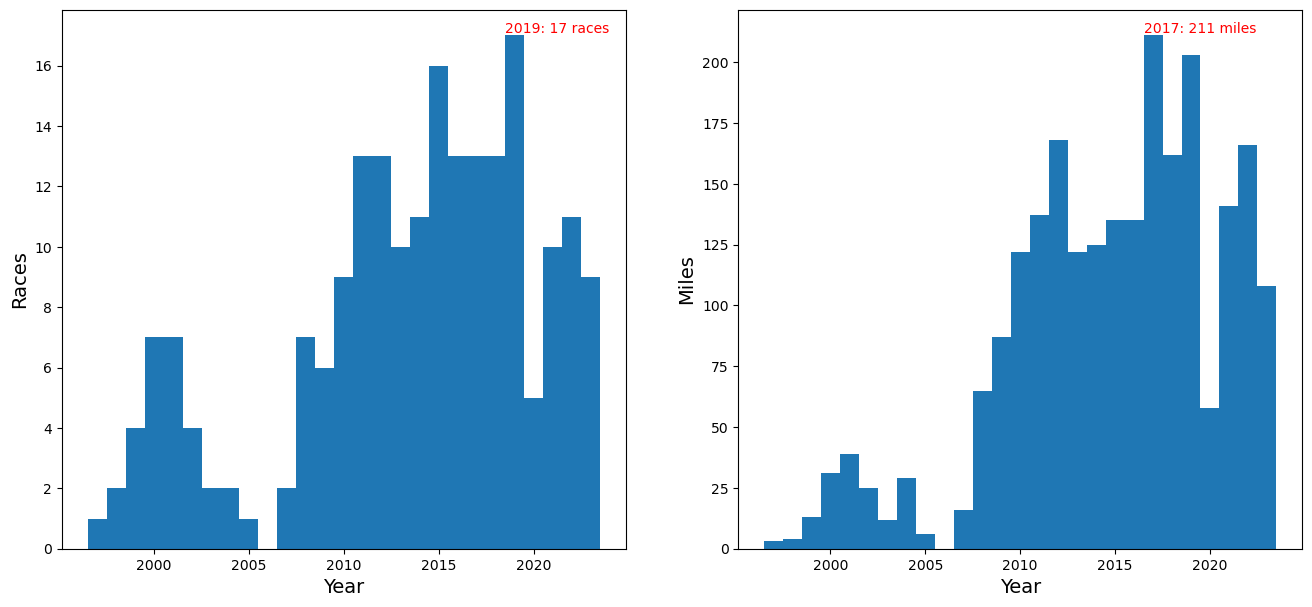

In [20]:
# Number of races per year
years = [x.year for x in pd.to_datetime(run.date, format='%m/%d/%y')]

# Number of total miles run each year in races
z = [(d.year,int(m)) for d,m in zip(pd.to_datetime(run.date, format='%m/%d/%y'),run.d_mi)]
l = [[a,]*b for a,b in z]
flat_list = [item for sublist in l for item in sublist]

# Number of total miles run each year in races
z = [(d.year,int(m)) for d,m in zip(pd.to_datetime(run.date, format='%m/%d/%y'),run.d_mi)]
l = [[a,]*b for a,b in z]
flat_list = [item for sublist in l for item in sublist]

fig,axarr = plt.subplots(1,2,figsize=(16,7))
eps = 0.5
bins = np.arange(min(years)-eps,max(years)+eps+1,1)

for ax,data,label in zip(axarr,(years,flat_list),('races','miles')):
    histobj = ax.hist(data,bins=bins)
    ax.set_xlabel("Year",fontsize=14)
    ax.set_ylabel(label.capitalize(),fontsize=14)
    label_max(histobj,ax,label);

### Total race miles

In [21]:
print("I've run {:.0f} total miles in {:d} races.".format(run['d_mi'].sum(),len(run)))

I've run 2359 total miles in 208 races.


In [22]:
d = 3.1
run[run['d_mi'] == d].sort_values(["d_km","time","date"],axis=0,ascending=[1,1,0])

,date,race,location,d_km,d_mi,pace,time,place_overall,finishers_overall,place_division,finishers_division,division
208,11/23/23,Woodinville Turkey Trot,"Woodinville, WA",5.0,3.1,5:51,18:09,19,1068,1,89,M 40-49
129,10/28/16,Run for the Horses,"Lexington, KY",5.0,3.1,5:51,18:09,2,75,1,4,M 30-34
156,11/22/18,Mukilteo Turkey Trot,"Mukilteo, WA",5.0,3.1,5:53,18:17,3,1049,1,45,M 35-39
113,8/29/15,Finley,"Georgetown, KY",5.0,3.1,5:57,18:29,4,1046,1,85,M 30-39
126,8/13/16,A Midsummer 5K,"Lexington, KY",5.0,3.1,5:59,18:34,35,2928,3,163,M 30-34
58,5/22/11,Sea Dog,"Cheshire, CT",5.0,3.1,6:03,18:48,4,530,1,25,M 20-29
186,10/3/21,Kilometers for the Kids,"Chapel Hill, NC",5.0,3.1,6:04,18:48,2,240,1,1,M 30-39
117,11/26/15,Thoroughbred Classic,"Lexington, KY",5.0,3.1,6:03,18:49,23,2599,5,101,M 30-34
123,4/16/16,The Race to Read,"Midway, KY",5.0,3.1,6:07,19:00,1,100,1,1,M 30-34
108,6/13/15,Lederhosenlauf,"St. Paul, MN",5.0,3.1,6:08,19:01,6,222,5,36,M 19-39
